In [120]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy import text

db_username = 'tupo'
db_password = 'npg_mbhaH6B3jdzy'
db_host = 'ep-bold-king-a52tlxdq-pooler.us-east-2.aws.neon.tech'
db_port = '5432'  # 默认为5432
db_name = 'day_ahead_spot'

conn = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')
query = "SELECT * FROM day_ahead_marginal_data;"
df = pd.read_sql_query(query, conn)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43872 entries, 0 to 43871
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         43872 non-null  object 
 1   time_slot                    43872 non-null  object 
 2   bidding_space                43872 non-null  float64
 3   renewable_load               43872 non-null  float64
 4   provincial_dispatch_load     43872 non-null  float64
 5   interconnection_plan         43872 non-null  float64
 6   day_ahead_online_capacity    43872 non-null  float64
 7   day_ahead_load_rate_percent  43872 non-null  float64
 8   day_ahead_clearing_price     43872 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.0+ MB


In [122]:
from datetime import timedelta
def estimate_clearing_price(engine, query_date, lookback_days=5):
    with engine.connect() as connection:
        start_date = query_date - timedelta(days=lookback_days)
        match_query = text("""
            SELECT date,time_slot,day_ahead_clearing_price
            FROM day_ahead_marginal_data
            WHERE 
                date BETWEEN :start_date AND date :query_date
        """)
        results = connection.execute(match_query, {
            "start_date": start_date,
            "query_date": query_date,
        })
        # print(results.fetchall())
        # print("Executing query:", match_query)
        print("With parameters:", start_date, query_date)
        df = pd.DataFrame(results.fetchall(), columns=results.keys())
        return df

In [123]:
target_date = datetime.strptime("2025-04-01", "%Y-%m-%d").date()
result_df = estimate_clearing_price(conn,target_date,3)

With parameters: 2025-03-29 2025-04-01


In [124]:
# 找到 time_slot 为 '00:00:00' 的行
midnight_row = result_df[result_df['time_slot'] == '00:00:00']

# 移除 time_slot 为 '00:00:00' 的行
result_df = result_df[result_df['time_slot'] != '00:00:00']

# 将 midnight_row 追加到 result_df 的末尾
result_df = pd.concat([result_df, midnight_row], ignore_index=True)

In [125]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   date                      384 non-null    object
 1   time_slot                 384 non-null    object
 2   day_ahead_clearing_price  384 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_price_boxplot(df):
    # 设置Seaborn风格
    sns.set_style("whitegrid")
    
    # 设置图形大小和DPI以提高清晰度
    plt.figure(figsize=(16, 9), dpi=100)
    
    # 创建箱型图，使用默认颜色
    ax = sns.boxplot(x='time_slot', y='day_ahead_clearing_price', data=df, 
                     width=0.6, linewidth=1.5)
    
    # 添加标题和轴标签，使用更好的字体和大小
    plt.title('Day-Ahead Clearing Prices Distribution by Time Slot', fontsize=18, pad=20)
    plt.xlabel('Time Slot', fontsize=14, labelpad=10)
    plt.ylabel('Clearing Price ($/MWh)', fontsize=14, labelpad=10)
    
    # 旋转X轴标签并对齐
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    
    # 添加网格线以便更好地对比价格
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # 添加均值线（可选）
    means = df.groupby('time_slot')['day_ahead_clearing_price'].mean().values
    plt.plot(range(len(means)), means, 'ro-', linewidth=2, markersize=6, 
             label='Mean Price')
    plt.legend(fontsize=12)
    
    # 紧凑布局并显示
    plt.figtext(0.01, 0.01, f"Data period: {df.index.min()} - {df.index.max()}", 
                fontsize=10, style='italic')
    plt.tight_layout()
    plt.savefig('clearing_price_by_timeslot_boxplot.png', bbox_inches='tight')
    plt.show()

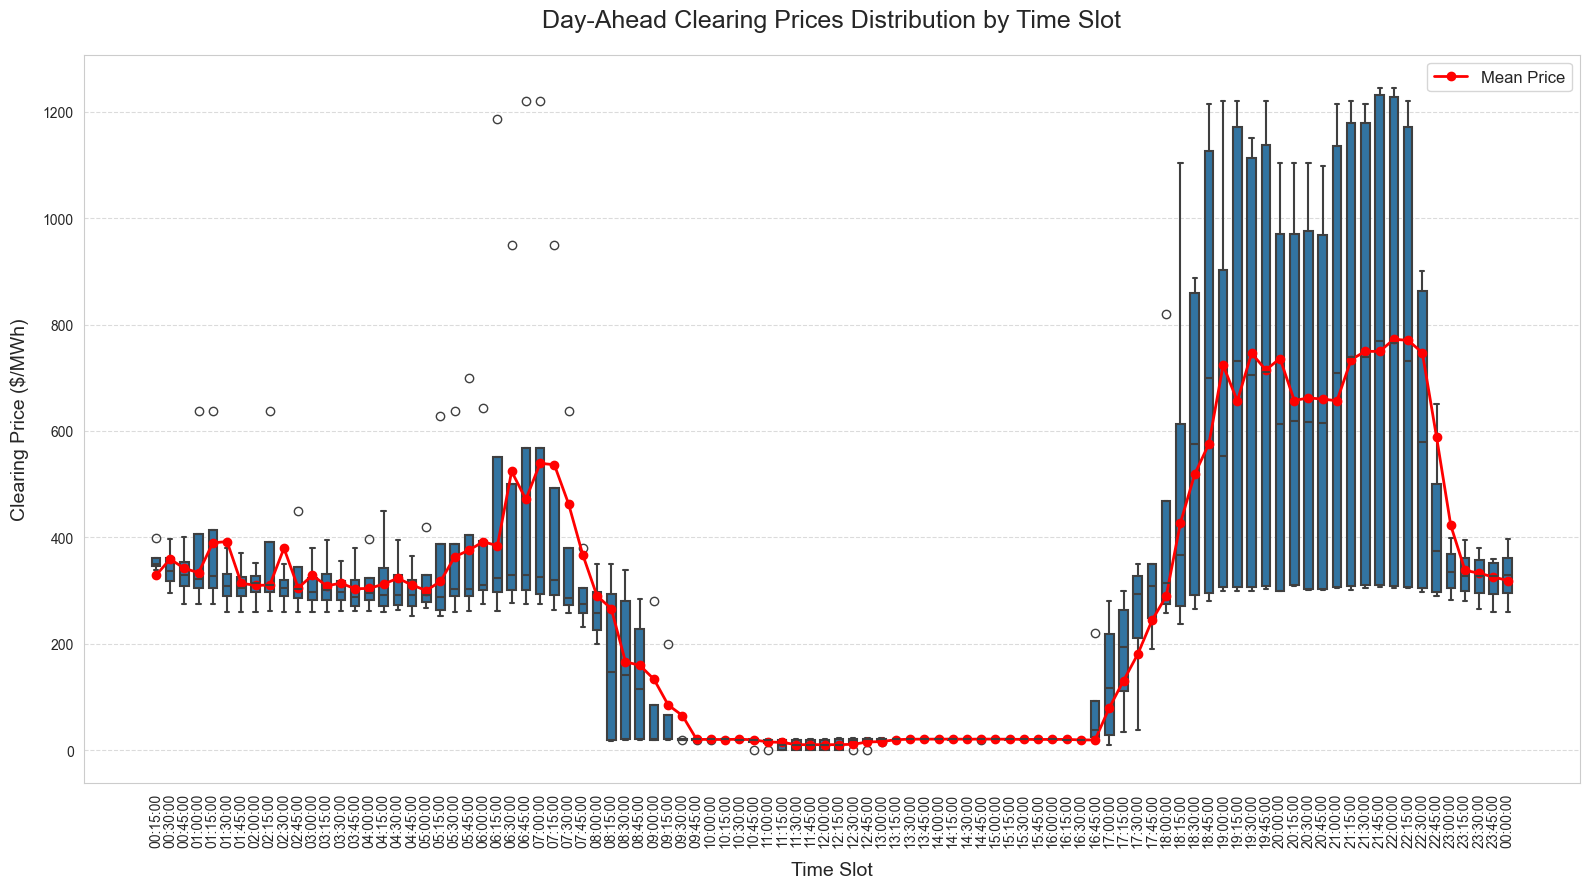

Text(0.01, 0.01, 'Data period: 0 - 43871')

<Figure size 640x480 with 0 Axes>

In [118]:
plot_price_boxplot(result_df)


In [ ]:
conn.connect().close()